# Baseline Model Development
This notebook implements a TF-IDF + SVM baseline for contract clause classification using the LegalBench CUAD dataset.

In [1]:
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Load and Preprocess Dataset

In [32]:
# Load datasets
dataset_cap = load_dataset("nguha/legalbench", "cuad_cap_on_liability", trust_remote_code=True)
dataset_audit = load_dataset("nguha/legalbench", "cuad_audit_rights", trust_remote_code=True)
dataset_insurance = load_dataset("nguha/legalbench", "cuad_insurance", trust_remote_code=True)

# Convert to DataFrames
df_cap = pd.DataFrame(dataset_cap['test'])
df_audit = pd.DataFrame(dataset_audit['test'])
df_insurance = pd.DataFrame(dataset_insurance['test'])

# Filter 'yes' examples
df_cap_yes = df_cap[df_cap['answer'].str.lower() == 'yes'].copy()
df_cap_yes.loc[:, 'class_label'] = 0  # cap_on_liability
df_audit_yes = df_audit[df_audit['answer'].str.lower() == 'yes'].copy()
df_audit_yes.loc[:, 'class_label'] = 1  # audit_rights
df_insurance_yes = df_insurance[df_insurance['answer'].str.lower() == 'yes'].copy()
df_insurance_yes.loc[:, 'class_label'] = 2  # insurance

# Filter 'no' examples and sample a subset (20% of 'yes' count)
df_cap_no = df_cap[df_cap['answer'].str.lower() == 'no'].sample(n=int(0.2 * len(df_cap_yes)), random_state=42).copy()
df_cap_no.loc[:, 'class_label'] = 3  # 'no' class
df_audit_no = df_audit[df_audit['answer'].str.lower() == 'no'].sample(n=int(0.2 * len(df_audit_yes)), random_state=42).copy()
df_audit_no.loc[:, 'class_label'] = 3  # 'no' class
df_insurance_no = df_insurance[df_insurance['answer'].str.lower() == 'no'].sample(n=int(0.2 * len(df_insurance_yes)), random_state=42).copy()
df_insurance_no.loc[:, 'class_label'] = 3  # 'no' class

# Combine all
df_combined = pd.concat([df_cap_yes, df_audit_yes, df_insurance_yes, df_cap_no, df_audit_no, df_insurance_no], ignore_index=True)

# Check for duplicates
print(f"Total clauses before deduplication: {len(df_combined)}")
df_combined = df_combined.drop_duplicates(subset=['text'], keep='first')
print(f"Total clauses after deduplication: {len(df_combined)}")

# Preprocess text
df_combined.loc[:, 'cleaned_text'] = df_combined['text'].apply(lambda x: x.strip().lower())

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df_combined['cleaned_text'],
    df_combined['class_label'],
    test_size=0.2,
    stratify=df_combined['class_label'],
    random_state=42
)
print(f'Training set size: {len(X_train)}, Test set size: {len(X_test)}')

Total clauses before deduplication: 2094
Total clauses after deduplication: 2052
Training set size: 1641, Test set size: 411


TF-IDF Vectorization and SVM Training

In [29]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train SVM
svm = SVC(kernel='linear', C=0.07, random_state=42)
svm.fit(X_train_tfidf, y_train)

SVC(C=0.07, kernel='linear', random_state=42)

Evaluate SVM and Visualize

Accuracy: 0.8516, Precision: 0.9036, Recall: 0.7605, F1: 0.7334


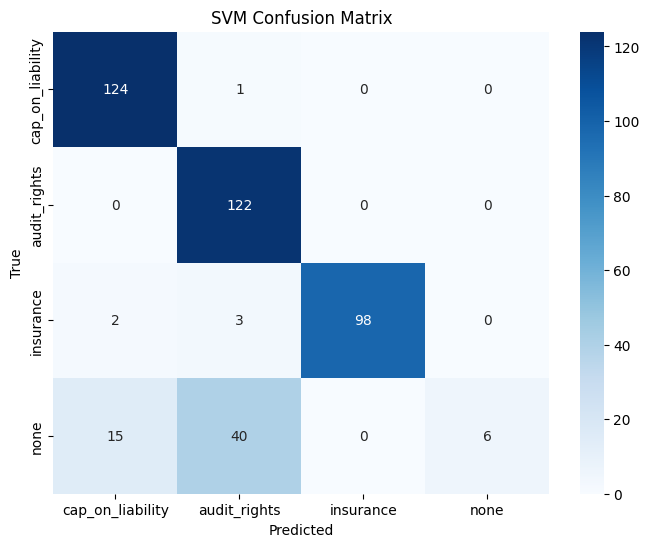

In [30]:
# Evaluate SVM
y_pred = svm.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['cap_on_liability', 'audit_rights', 'insurance', 'none'],
            yticklabels=['cap_on_liability', 'audit_rights', 'insurance', 'none'])
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Save Model and Vectorizer

In [31]:
# Save model and vectorizer
import joblib
joblib.dump(svm, 'svm_baseline_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']